# Tensorflow Serving for Image Recognition

In [2]:
import tensorflow as tf
import tensorflow_model_analysis as tfma
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import base64

print("TF Version: {}".format(tf.__version__))
print("Numpy Version: {}".format(np.__version__))

TF Version: 1.14.0
Numpy Version: 1.17.3


## Data Preparation

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
if os.path.exists("/Users/jiankaiwang/devops/tmp/MNIST_data/"):
  mnist = input_data.read_data_sets("/Users/jiankaiwang/devops/tmp/MNIST_data/", one_hot=True)
else:
  mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /Users/jiankaiwang/devops/tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /Users/jiankaiwang/devops/tmp/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /Users/jiankaiwang/devops/tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/jiankaiwang/devops/tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
def create_tf_example(imgInByte, labelInByte):
    tf_example = tf.train.Example(features=tf.train.Features(feature={\
    'image': _bytes_feature(imgInByte) \
    , 'label': _bytes_feature(labelInByte) \
    }))
    return tf_example

In [7]:
def Base64Converter(byte_string):
    _byteStr = base64.b64encode(byte_string)
    return _byteStr[:-2].replace(b"+", b"-").replace(b"/", b"_")

In [95]:
with tf.python_io.TFRecordWriter("/Users/jiankaiwang/Desktop/mnist_test.tfrecord") as writer:
    for i in range(mnist.test.num_examples):
        writer.write(
            create_tf_example(
                Base64Converter(mnist.test.images[i].astype("float32").tobytes()),  # [None, 784]
                Base64Converter(mnist.test.labels[i].astype("float32").tobytes())   # [None, 10]
            ).SerializeToString()
        )

In [96]:
def writeTFRecords(obj):
    obj.write(
        create_tf_example(
            Base64Converter(mnist.test.images[i].astype("float32").tobytes()),  # [None, 784]
            Base64Converter(mnist.test.labels[i].astype("float32").tobytes())   # [None, 10]
        ).SerializeToString()
    )

with tf.python_io.TFRecordWriter("/Users/jiankaiwang/Desktop/mnist_test_1.tfrecord") as writer1:
    with tf.python_io.TFRecordWriter("/Users/jiankaiwang/Desktop/mnist_test_2.tfrecord") as writer2:
        for i in range(mnist.test.num_examples):
            if i % 2 == 0:
                writeTFRecords(writer1)
            else:
                writeTFRecords(writer2)

## Model Generation

### Quick Test between np.tobytes() and tf.decode_raw()

In [8]:
import matplotlib.pyplot as plt

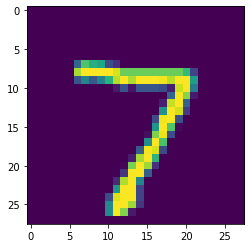

In [9]:
_img = mnist.test.images[0]
img = np.reshape(_img, [28,28])
plt.imshow(img)
img_ = img.tobytes()

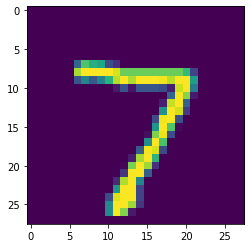

In [10]:
tf.reset_default_graph()
with tf.Graph().as_default():
    img_p = tf.io.decode_raw(img_, tf.float32)
    with tf.Session() as sess:
        decode_img = sess.run(img_p)
        decode_img = np.reshape(decode_img, [28,28])

plt.imshow(decode_img)

### Quick Test between np.tobytes() and tf.decode_base64()

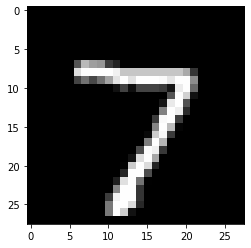

In [11]:
img_b64_es = base64.b64encode(mnist.test.images[0].astype("float32").tobytes())
img_b64_ds = base64.b64decode(img_b64_es)
img_d = np.frombuffer(img_b64_ds, dtype="float32")
img_d_shape = img_d.reshape([28, 28])
plt.imshow(img_d_shape, cmap="gray")

In [12]:
tf.reset_default_graph()

with tf.Graph().as_default():
    img = tf.placeholder(tf.string)
    b64s = tf.io.encode_base64(img)
    encoded_image = tf.io.decode_base64(b64s)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        b64s_di, b64s_e = sess.run([encoded_image, b64s], 
                                   feed_dict={img: mnist.test.images[0].astype("float32").tobytes()})
        print(len(b64s_e))

4182


In [13]:
print(len(img_b64_es))
img_b64_es[:-2].replace(b"+",b"-").replace(b"/",b"_") == b64s_e

4184


True

Input may or may not have padding at the end. See EncodeBase64 for padding. Web-safe means that input must use - and _ instead of + and /. 

Tensorflow encoding is different from base64 in web-safe base64 url. Two steps make both of them are the same.
* Trim final 2 bytes.
* Replace byte '+' with '-' and byte '/' with '_'.

Saving byte string in numpy.array issue, trimimg zeros at the end of byte string.

In [14]:
_train_images = []
_bytes_array = []

for i in range(mnist.train.num_examples):
    byte_data = mnist.train.images[i].astype("float32").tobytes()
    byte_string = Base64Converter(byte_data)  # convert to base64 encoded string
    _train_images.append(byte_string)
    _bytes_array.append(len(byte_string))

# dtype='O' (big O) means python object
train_images = np.array(_train_images, dtype='O')
train_images = train_images.reshape([-1,1])
print(train_images.shape)

(55000, 1)


In [15]:
tf.reset_default_graph()
with tf.Graph().as_default():
    b64s_input = tf.placeholder(tf.string, shape=[None,1])
    raw_input = tf.io.decode_base64(b64s_input)  # to byte
    decode = tf.io.decode_raw(raw_input, tf.float32)
    with tf.Session() as sess:
        img_ = sess.run(decode, feed_dict={b64s_input: train_images[9:11]})
        print(img_.shape)

print(_bytes_array[:10])
print(len(_train_images[0]), len(_train_images[1]))

(2, 1, 784)
[4182, 4182, 4182, 4182, 4182, 4182, 4182, 4182, 4182, 4182]
4182 4182


In [16]:
_train_labels = []

for i in range(mnist.train.num_examples):
    byte_data = mnist.train.labels[i].astype("float32").tobytes()
    label_byte = Base64Converter(byte_data)
    _train_labels.append(label_byte)
    
train_labels = np.array(_train_labels, dtype="O")
train_labels = train_labels.reshape([-1, 1])
train_labels.shape

(55000, 1)

### Customized Models

In [17]:
def layer(input, weight_shape, bias_shape):
    weight_std = (2.0 / weight_shape[0]) ** 0.5
    w_init = tf.random_normal_initializer(stddev=weight_std)
    b_init = tf.constant_initializer(value=0)
    W = tf.get_variable(name="W", shape=weight_shape, initializer=w_init)
    b = tf.get_variable(name="b", shape=bias_shape, initializer=b_init)
    return tf.nn.relu(tf.matmul(input, W) + b)

In [18]:
def evaluate(output, y):
  compare = tf.equal(tf.argmax(output, axis=1), tf.argmax(y, axis=1))
  compare_to_float = tf.cast(compare, tf.float32)
  accuracy, updated_op = tf.metrics.mean(compare_to_float)
  return accuracy, updated_op

In [19]:
def model_fn(features, labels, mode, params):
    
    # image input transformation from base64 encoded string to byte string and then to float32
    _input = tf.io.decode_base64(features["image"])
    _input = tf.io.decode_raw(_input, tf.float32)
    new_input = tf.squeeze(_input, axis=1) # [None, 1, 784] => [None, 784]
    
    if mode in [tf.estimator.ModeKeys.TRAIN, tf.estimator.ModeKeys.EVAL]:
        # The labels are only used in TRAIN and EVAL modess.
        # label input transform from string to float32
        labels = tf.io.decode_base64(labels)
        labels = tf.io.decode_raw(labels, tf.float32) 
        labels = tf.squeeze(labels, axis=1) # [None, 1, 10] => [None, 1]
    
    # build a mlp model
    with tf.variable_scope("hidden1"):
        hidden1 = layer(new_input, [784, 1024], [1024])
    with tf.variable_scope("hidden2"):
        hidden2 = layer(hidden1, [1024, 512], [512])
    with tf.variable_scope("output"):
        output = layer(hidden2, [512, 10], [10])
    
    # define the result
    result = tf.identity(output, name="class")
    prob = tf.nn.softmax(result, name="prob")
    predict_dict = {"output": output, "prob": prob}
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=predict_dict)
    
    # define loss function
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=labels)
    loss = tf.reduce_mean(cross_entropy)
    
    # define optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params["learning_rate"])
    train_opt = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    # metrics
    eval_metric_ops = {
        #"accuracy": tf.metrics.accuracy(labels, output)
        "accuracy": evaluate(output, labels)
    }
    
    # return an estimator spec
    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_opt,
        eval_metric_ops=eval_metric_ops)

In [20]:
batch_size = 128
epochs = mnist.train.num_examples // batch_size

model_params = {"learning_rate": 1e-4}

In [21]:
nn = tf.estimator.Estimator(model_fn=model_fn, params=model_params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/4b/wh1nthj1563b1gl58ydgwnfw0000gp/T/tmpugbau_ba', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13d5f2048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": train_images},
    y=train_labels,
    num_epochs=epochs,
    shuffle=True, 
    batch_size=batch_size)

# Train
nn.train(input_fn=train_input_fn, steps=200)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/4b/wh1nthj1563b1gl58ydgwnfw0000gp/T/tmpugbau_ba/model.ckpt.
INFO:tensorflow:loss = 2.3351197, step = 1
INFO:tensorflow:global_step/sec: 78.5751
INFO:tensorflow:loss = 2.2912858, step = 101 (1.274 sec)
INFO:tens

### Evaluating Model

In [23]:
# image transformation from float32 to byte string
_test_images = []

for i in range(mnist.test.num_examples):
    byte_data = mnist.test.images[i].astype("float32").tobytes()
    byte_data = Base64Converter(byte_data)
    byte_string = np.array(byte_data).tostring()
    _test_images.append(byte_string)

test_images = np.array(_test_images, dtype='O')
test_images = test_images.reshape([-1, 1])
print(test_images.shape)

# label transformation from float32 to byte string
_test_labels = []

for i in range(mnist.test.num_examples):
    label_byte = mnist.test.labels[i].astype("float32").tobytes()
    label_byte = Base64Converter(label_byte)
    _test_labels.append(label_byte)
    
test_labels = np.array(_test_labels, dtype="O")
test_labels = test_labels.reshape([-1, 1])
print(test_labels.shape)

(10000, 1)
(10000, 1)


In [24]:
# Score accuracy
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": test_images},
    y=test_labels,
    num_epochs=1,
    shuffle=False)

ev = nn.evaluate(input_fn=test_input_fn)
print("Loss: %s" % ev["loss"])
print("Accuracy: %s" % ev["accuracy"])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-04T18:05:21Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /var/folders/4b/wh1nthj1563b1gl58ydgwnfw0000gp/T/tmpugbau_ba/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-04-18:05:21
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.1373, global_step = 200, loss = 2.2944782
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /var/folders/4b/wh1nthj1563b1gl58ydgwnfw0000gp/T/tmpugbau_ba/model.ckpt-200
Loss: 2.2944782
Accuracy: 0.1373


## Prediction

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/4b/wh1nthj1563b1gl58ydgwnfw0000gp/T/tmpugbau_ba/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction (pred 2: 0.13284893): [0.09364577 0.09191748 0.13284893 0.09191748 0.09191748 0.09191748
 0.09191748 0.09191748 0.09191748 0.13008298]


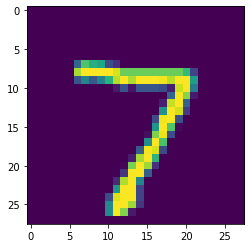

In [25]:
used_index = 0
pred_data = mnist.test.images[used_index].astype('float32').tobytes()
pred_data = Base64Converter(pred_data)
pred_data = np.array(pred_data, dtype="O").reshape([-1, 1])

plt.imshow(mnist.test.images[used_index].reshape(28, 28))

# Print out predictions
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": pred_data},
    num_epochs=1,
    shuffle=False)

import struct
predictions = nn.predict(input_fn=predict_input_fn)
for _, p in enumerate(predictions):
    pred_class = np.argmax(p["prob"])
    prob = p["prob"][pred_class]
    print("Prediction (pred %s: %s): %s" % (pred_class, prob, p["prob"]))

## Model Export

In [30]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders"""
    serialized_tf_example = tf.placeholder(dtype=tf.string, shape=[None, 1])
    receiver_tensors = {'image': serialized_tf_example}
    return tf.estimator.export.ServingInputReceiver(receiver_tensors, serialized_tf_example)

serving_input_receiver_fn()

ServingInputReceiver(features={'image': <tf.Tensor 'Placeholder_2:0' shape=(?, 1) dtype=string>}, receiver_tensors={'input': <tf.Tensor 'Placeholder_2:0' shape=(?, 1) dtype=string>}, receiver_tensors_alternatives=None)

In [31]:
if os.path.exists("/Users/jiankaiwang/Desktop/TFE_SavedModel/"):
    exported_name = nn.export_saved_model("/Users/jiankaiwang/Desktop/TFE_SavedModel/", serving_input_receiver_fn)
else:
    exported_name = nn.export_saved_model("/tmp/TFE_SavedModel/", serving_input_receiver_fn)
    
outmodel = exported_name.decode("UTF-8")
print(outmodel)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /var/folders/4b/wh1nthj1563b1gl58ydgwnfw0000gp/T/tmpugbau_ba/model.ckpt-200
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /Users/jiankaiwang/Desktop/TFE_SavedModel/temp-b'1575454152'/saved_model.pb
/Users/jiankaiwang/Desktop/TFE_SavedModel/1575454152


In [32]:
!saved_model_cli show --dir /Users/jiankaiwang/Desktop/TFE_SavedModel/1575454152 --tag_set serve --signature_def serving_default

/Users/jiankaiwang/devops/pyenv/tfx/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jiankaiwang/devops/pyenv/tfx/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jiankaiwang/devops/pyenv/tfx/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jiankaiwang/devops/pyenv/tfx/lib/pyt

## Restful API requests for Prediction

In [33]:
import json
import requests
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import base64
import numpy as np

In [34]:
if os.path.exists("/Users/jiankaiwang/devops/tmp/MNIST_data/"):
  mnist = input_data.read_data_sets("/Users/jiankaiwang/devops/tmp/MNIST_data/", one_hot=True)
else:
  mnist = input_data.read_data_sets("/tmp/MNIST_data/", one_hot=True)

Extracting /Users/jiankaiwang/devops/tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/jiankaiwang/devops/tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/jiankaiwang/devops/tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/jiankaiwang/devops/tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


In [35]:
def Base64Converter(byte_string):
    _byteStr = base64.b64encode(byte_string)
    return _byteStr[:-2].replace(b"+", b"-").replace(b"/", b"_")

def Base64ConverterOri(byte_string):
    _byteStr = base64.b64encode(byte_string)
    return _byteStr

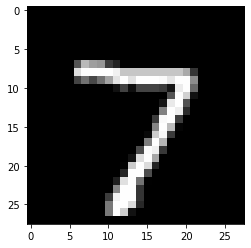

Label: 7


In [56]:
use_idx = 0

# must be inputs (vector) or instances (list)
b64eUTF8Ori = Base64Converter(mnist.test.images[use_idx].tobytes()).decode('UTF-8')
my_data = {"instances": []}
my_data["instances"].append([b64eUTF8Ori])

plt.imshow(mnist.test.images[use_idx].reshape(28, 28), cmap='gray')
plt.show()

print("Label: {}".format(np.argmax(mnist.test.labels[use_idx])))
#print("Sent data: {}".format(my_data))

In [61]:
"""
# or you can use the default base64 converter in tensorflow
def ImgBase64(byteData):
  tf.reset_default_graph()
  with tf.Graph().as_default():
    inputs = tf.placeholder(tf.string)
    base64Encode = tf.io.encode_base64(inputs)
    with tf.Session() as sess:
      outputs = sess.run(base64Encode, feed_dict={inputs: byteData})
    return outputs

b64e = ImgBase64(mnist.test.images[0].tobytes())
b64eUTF8 = b64e.decode("UTF-8")

my_data = {"instances": []}
my_data["instances"].append([b64eUTF8])
"""

'\n# or you can use the default base64 converter in tensorflow\ndef ImgBase64(byteData):\n  tf.reset_default_graph()\n  with tf.Graph().as_default():\n    inputs = tf.placeholder(tf.string)\n    base64Encode = tf.io.encode_base64(inputs)\n    with tf.Session() as sess:\n      outputs = sess.run(base64Encode, feed_dict={inputs: byteData})\n    return outputs\n\nb64e = ImgBase64(mnist.test.images[0].tobytes())\nb64eUTF8 = b64e.decode("UTF-8")\n\nmy_data = {"instances": []}\nmy_data["instances"].append([b64eUTF8])\n'

Use the default base64 converter in tensorflow.

In [62]:
serving_url = "http://localhost:8501/v1/models/TFE_SavedModel:predict"

r = requests.post(serving_url,
                  data=json.dumps(my_data),
                  headers={'Content-Type': 'application/octet-stream'})
print(r.status_code, r.content)

200 b'{\n    "predictions": [\n        {\n            "output": [0.0186281614, 0.0, 0.368321508, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.347281367],\n            "prob": [0.0936457738, 0.0919174775, 0.132848933, 0.0919174775, 0.0919174775, 0.0919174775, 0.0919174775, 0.0919174775, 0.0919174775, 0.13008298]\n        }\n    ]\n}'


## Read the tfrecords

In [101]:
def read_and_decode(filename_queue):
    # create a tfrecord object
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    # decode the example
    features = tf.parse_single_example(serialized_example,\
                features={'image':tf.FixedLenFeature([], tf.string)\
                          , 'label':tf.FixedLenFeature([], tf.string)})
    
    label = tf.io.decode_base64(features["label"])
    label = tf.io.decode_raw(label, tf.float32)
    
    # it must decode byteslist from string type to uint8 type
    image = tf.io.decode_base64(features["image"])
    image = tf.io.decode_raw(image, tf.float32)
    return image, label

In [102]:
tf.reset_default_graph()

with tf.name_scope('input'):
    # return a QueueRunner object and FIFOQueue object inside in
    filename_queue = tf.train.string_input_producer(
        ["/Users/jiankaiwang/Desktop/mnist_test.tfrecord"], 
        num_epochs=None)
    
    image, label = read_and_decode(filename_queue)
    
    with tf.Session() as sess:

        # because one epoch variable is built inside string_input_produer (image_raw)
        # and the variable is belonging to tf.GraphKeys.LOCAL_VARIABLES
        # tf.local_variables_initializer() is necessary
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)

        coord=tf.train.Coordinator()
        threads= tf.train.start_queue_runners(coord=coord)
        
        for i in range(0, 3, 1):
            img, lbl = sess.run([image, label])
            print(lbl)

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[{{node input/input_producer/input_producer_EnqueueMany}}]]


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[{{node input/input_producer/input_producer_EnqueueMany}}]]
